# from importlib import reload
import sys
sys.path.append("../src")
import brownian
import time_series
import acoustic_entrainment
reload(brownian)
reload(time_series)
from time_series import find_files, find_ders, Collection, bin_func, TimeSeries
from acoustic_entrainment import VelocityResponse
import brownian
import time_series
reload(brownian)
reload(time_series)
from time_series import find_files, find_ders, Collection, bin_func
from brownian import abc_guess, get_krhoA, psd_func, logbin_func
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

from os import path

# New function definitions

In [2]:
def sort_fnames(fnames, include=None):
    """
    Sort file names of the form <path>/iter_i by the iteration index i. 
    Include files with aspecific iteration index by passing a list to include. 
    """
    iters = [int(fname.split("_")[-1].split(".tdms")[0]) for fname in fnames]
    fnames_sorted = [fname for _, fname in sorted(zip(iters, fnames))]
    iters = sorted(iters)
    if include is not None:
        fnames_sorted = [fname for fname, itr in zip(fnames_sorted, iters) if itr in include]
    return fnames_sorted

# Directory structure

In [3]:
# Data by date
base_der = "/data/brownian"
date_ders = find_ders(base_der)
date_ders

['/data/brownian/20211215', '/data/brownian/20220330']

In [4]:
# Select a date
date_der_index = 0
bead_ders = find_ders(date_ders[date_der_index])
bead_ders

['/data/brownian/20211215/bead1']

In [5]:
# Select a bead
bead_der_index = 0
experiment_ders = find_ders(bead_ders[bead_der_index])
experiment_ders

['/data/brownian/20211215/bead1/pulse1']

In [6]:
# Select an experiment
experiment_der_index = 0
fnames = find_files(experiment_ders[experiment_der_index])
fnames

['/data/brownian/20211215/bead1/pulse1/iter_8.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_9.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_5.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_7.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_4.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_10.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_1.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_3.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_6.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_2.tdms']

In [7]:
sort_fnames(fnames, include=[1,3])

['/data/brownian/20211215/bead1/pulse1/iter_1.tdms',
 '/data/brownian/20211215/bead1/pulse1/iter_3.tdms']

# PSD calibration

0 [2.02093828e-05 1.33413346e+03 6.42410492e+05 2.94056893e+02]
1 [2.16624316e-05 1.39412759e+03 6.64603510e+05 2.94056664e+02]
2 [2.23693901e-05 1.41984200e+03 6.63648340e+05 2.94044490e+02]
3 [2.17581047e-05 1.41084095e+03 6.44733886e+05 2.94025260e+02]
4 [2.12871713e-05 1.37005951e+03 6.24427868e+05 2.94038118e+02]
5 [2.19268422e-05 1.41187545e+03 6.38982872e+05 2.94027627e+02]
6 [2.21941592e-05 1.43663004e+03 6.65462522e+05 2.94008778e+02]
7 [2.22427920e-05 1.42823641e+03 6.37657454e+05 2.93995540e+02]
8 [2.16933578e-05 1.40883454e+03 6.41071866e+05 2.93999260e+02]
9 [2.17375966e-05 1.38677005e+03 6.31530324e+05 2.93974596e+02]


(1e-25, 1.0647510264775781e-18)

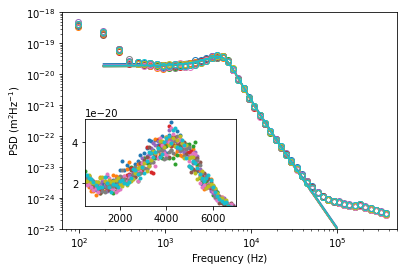

In [107]:
fmin = 5e2
fmax = 4e4
bin_average_Npts = 32
cutoff = 500e3

fig, ax = plt.subplots(1,1, figsize=(6,4))
axins = inset_axes(ax, width="45%", height="40%", loc="lower left", borderpad=2.3)


krhoATs = []
for fnamei, fname in enumerate(sort_fnames(fnames)):
    color = f"C{fnamei}"
    C = Collection(fname)
    T = np.mean(C.Ts) + 273.15
    C.set_collection("X")
    C.apply("detrend", inplace=True, mode="constant")
    C.apply("lowpass", cutoff=cutoff, order=3, inplace=True)
    C.apply("bin_average", Npts=bin_average_Npts, inplace=True)
    
    freq, psd = C.average("PSD", taumax=100e-3)
    mask = np.logical_and(freq>fmin, freq<fmax)
    abc, abc_cov = abc_guess(freq[mask], psd[mask], n=C.Navg_psd)
    krhoA = get_krhoA(*abc, C.R, T)
    k, rho, A = krhoA
    krhoAT = np.r_[krhoA, T]
    krhoATs.append(krhoAT)    
    print(fnamei, krhoAT)
    psd /= A*A
    
    logfreq  = logbin_func(freq, Npts=20)
    logpsd  = logbin_func(psd, Npts=20)
    logmask = np.logical_and(logfreq>fmin, logfreq<fmax)
    ax.loglog(logfreq, logpsd, mec=color, mfc="none", marker="o", ls="none")
    line_mask = np.logical_and(freq>100, freq<1e5)
    ax.loglog(freq[line_mask], psd_func(freq, k, rho, T, C.R)[line_mask], c=color)
    axins.plot(freq, psd, c=color, marker=".", ls="none")
    axins.set_xlim(500, 7000)
    axins.set_ylim(0.9e-20, 5.1e-20)
    
krhoATs = np.array(krhoATs)
ax.set_ylabel(r"PSD $\rm (m^2 Hz^{-1})$")
ax.set_xlabel(r"Frequency (Hz)")
ax.set_xlim(right=cutoff)
ax.set_ylim(bottom=1e-25)

k : 21.70812284515143 0.5862004316384712 2.7003736611404
rho : 1400.1350007715912 28.833190365362412 2.059315019585463
A : 1.5499893519442831 0.03259523504305466 2.1029328364203077
T : 20.872722357946856 0.026193345345563154 0.12549079557698703


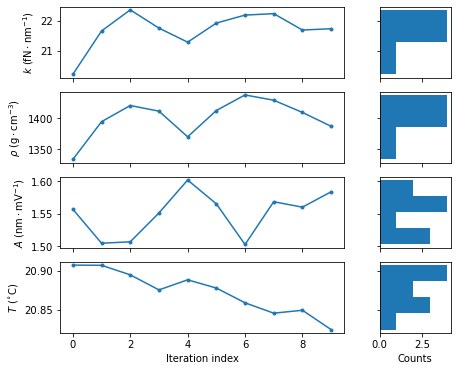

In [108]:
fig, axs = plt.subplots(4,2, figsize=(7, 6), gridspec_kw={"width_ratios":[0.8, 0.2]}, sharey="row", sharex="col")

ylabels = [r"$k~{\rm (fN \cdot nm^{-1})}$", r"$\rho~{\rm (g \cdot cm^{-3})}$", r"$A~{\rm (nm \cdot mV^{-1})}$", r"$T~{\rm (^{\circ}C)}$"]

for parami, param in enumerate(["k", "rho", "A", "T"]):
    vals = krhoATs[:, parami]
    # units
    if param == "k":
        vals = vals * 1e15 / 1e9
    if param =="A":
        vals = 1/vals * 1e9/1e3
    if param == "T":
        vals = vals -273.15
    # plot data
    axs[parami, 0].plot(vals, marker=".")
    axs[parami, 1].hist(vals, bins=4, orientation="horizontal")
    # labels
    axs[parami, 0].set_ylabel(ylabels[parami])
    axs[3, 0].set_xlabel("Iteration index")
    axs[3, 1].set_xlabel("Counts")
    print(param, ":", np.mean(vals), np.std(vals), 100*np.std(vals)/np.mean(vals))
    


# 100-trial time-domain averages

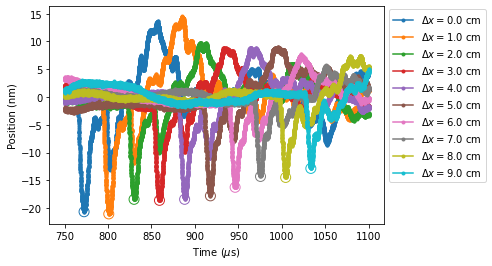

In [109]:
fig, ax = plt.subplots(1,1, figsize=(6,4))


Npts = 32
tmin = 750e-6
tmax = 1100e-6
recordi = "average"
#recordi = 0
poses = []
tpeaks = []
Vpeaks = []
for fnamei, fname in enumerate(sort_fnames(fnames)):
    cal = 1 / krhoATs[fnamei, -2]
    color = f"C{fnamei}"
    C = Collection(fname)
    pos = C.pos - 1
    poses.append(pos)
    
    C.set_collection("X", bin_average=Npts)

    if recordi == "average":
        t, x = C.aggrigate()
    else:
        t, x = C.collection[recordi]()

    mask = np.logical_and(t>tmin, t<tmax)
    tm, xm = t[mask], x[mask]
    xm -= np.mean(xm)
    peakdex = np.argmin(xm)
    tpeak = tm[peakdex]
    Vpeak = xm[peakdex]
    tpeaks.append(tpeak)
    Vpeaks.append(Vpeak)
    ax.plot(1e6*tm, 1e9*cal*xm, marker=".", color=color, label="$\Delta x = $%s cm"%pos)
    ax.scatter([1e6*tpeak], [1e9*cal*Vpeak], marker="o", ec=color, fc="none", s=100)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.01))

delta_ts = np.array(tpeaks)-tpeaks[0]
poses = np.array(poses)

ax.set_ylabel("Position (nm)")
ax.set_xlabel(r"Time ($\mu$s)");

Text(0, 0.5, 'velocity ${\\rm (mm s^{-1})}$')

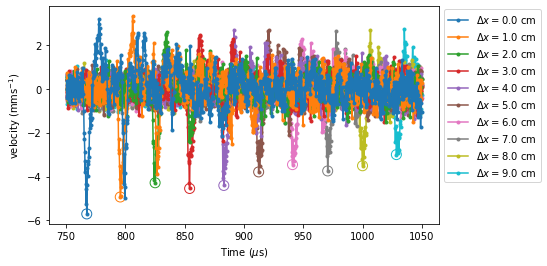

In [111]:
fig, ax = plt.subplots(1,1, figsize=(7,4))


Npts = 16
tmin = 750e-6
tmax = 1050e-6
recordi = "average"
#recordi = 0
poses = []
tpeaks = []
Vpeaks = []
for fnamei, fname in enumerate(sort_fnames(fnames)):
    cal = 1 / krhoATs[fnamei, -2]
    color = f"C{fnamei}"
    C = Collection(fname)
    pos = C.pos - 1
    poses.append(pos)
    
    C.set_collection("X")
    C.apply("bin_average",  Npts=Npts/2, inplace=True)
    C.apply("differentiate", inplace=True)

    if recordi == "average":
        t, x = C.aggrigate()
    else:
        t, x = C.collection[recordi]()

    mask = np.logical_and(t>tmin, t<tmax)
    tm, xm = t[mask], x[mask]
    xm -= np.mean(xm)
    peakdex = np.argmin(xm)
    tpeak = tm[peakdex]
    Vpeak = xm[peakdex]
    tpeaks.append(tpeak)
    Vpeaks.append(Vpeak)
    ax.plot(1e6*tm, 1e3*cal*xm, marker=".", color=color, label="$\Delta x = $%s cm"%pos, zorder=len(fnames)-fnamei)
    ax.scatter([1e6*tpeak], [1e3*cal*Vpeak], marker="o", ec=color, fc="none", s=100)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.01))

delta_ts = np.array(tpeaks)-tpeaks[0]
poses = np.array(poses)

#ax.set_ylabel("Velocity ${\rm (mm \cdot s^{-1})}$")
ax.set_xlabel(r"Time ($\mu$s)")
ax.set_ylabel(r"velocity ${\rm (mm s^{-1})}$")

342.6350901655324


Text(0.5, 0, 'Source displacement D (cm)')

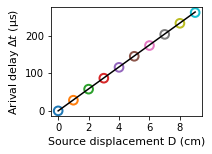

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(2.7, 2.))
def slope(x, m):
    return m*x

def slope_quad(x, a, b):
    return a*x + b*x*x


popt, pcov = curve_fit(slope, poses, delta_ts, p0=[1/344.0], bounds=[(0,), (np.inf)])
speed = 1 / popt[0]
print(speed*1e-2)
plt.plot(poses, 1e6*poses/speed, c="k")
#popt2, pcov2 = curve_fit(slope_quad, poses, delta_ts, p0=[1/344.0, 0], bounds=[(0,0), (np.inf, np.inf)])
#plt.plot(poses, 1e6*poses*(popt2[0]+poses*popt2[1]), c="k", ls="--")
for fnamei, (pos, dt) in enumerate(zip(poses, delta_ts)):
    color = f"C{fnamei}"
    ax.scatter([pos], [1e6*dt],  marker="o", ec=color, fc="none", s=75, lw=2)
ax.set_ylabel(r"Arival delay $\Delta t$ (${\rm \mu}$s)", size=11)
ax.set_xlabel("Source displacement D (cm)", size=11)
#ax.text(0.25, 155, f"{round(speed*1e-2, 2)} m/s", fontsize=11)
#plt.savefig("figures/wave_speed.png", bbox_inches="tight", dpi=600)

# Single Shot time-domain

In [118]:
import acoustic_entrainment
import brownian
import time_series
import constants
reload(acoustic_entrainment)
reload(brownian)
reload(time_series)
reload(constants)
from time_series import Collection
from acoustic_entrainment import VelocityResponse

fnamei = 0
c0 = 342.64
fname = sort_fnames(fnames)[fnamei]
C = Collection(fname)
k, rho, A, T = krhoATs[fnamei]
bead_cal = 1/A
R = C.R
response = VelocityResponse(R=C.R, rho=C.rho, T=C.T, c0=344, k=C.k)

In [115]:
-5e-3/c0

-1.4592575297688536e-05

41
625000.0
41
625000.0
41
625000.0
41
625000.0


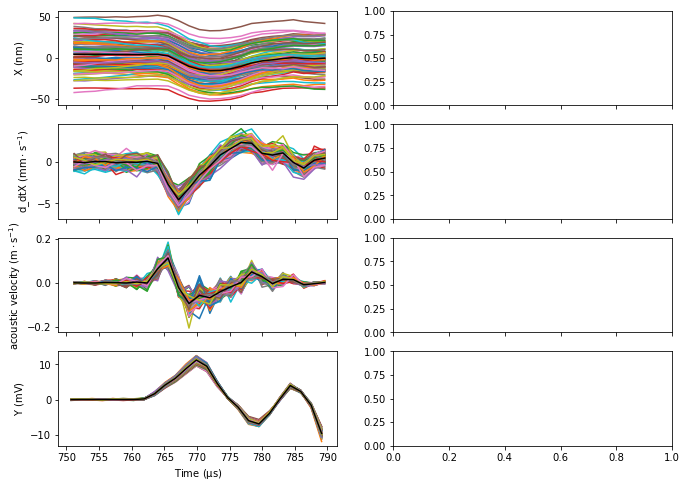

In [149]:
fig, axs = plt.subplots(4,2, figsize=(11, 8), sharex="col")
plot_tmin, plot_tmax = 750e-6, 790e-6
tpad = 10e-6
cutoff = 3e5
mic_tshift = 4e-3/c0

correction_tmin, correction_tmax = plot_tmin - tpad, plot_tmax + tpad
Cx = Collection(fname)
Cv = Collection(fname)
Cp = Collection(fname)
Cmic = Collection(fname)
Cs = [Cx, Cv, Cp, Cmic]
units = ["nm", "mm_s", "m_s", "mV"]
for C in Cs:
    if C == Cmic:
        ch ="Y"
        cal = -1.0
    else:
        ch = "X"
        cal = bead_cal
    C.set_collection(ch)
    C.apply("calibrate", cal=cal, inplace=True)
    C.apply("detrend", mode="constant", inplace=True)
    #C.apply("lowpass", cutoff=300e3, order=3, inplace=True)
    Npts = int(C.r / (2*cutoff))
    C.apply("bin_average", Npts=Npts, inplace=True)
    
for C in [Cv, Cp]:
    C.apply("differentiate", inplace=True)
    #C.apply("lowpass", cutoff=20e3, order=3, inplace=True)

Cp.apply_func(response.correct_signal, tmin=correction_tmin, tmax=correction_tmax,
              correction="bassetbound", window="blackmanharris", impedance=None, r0=5e-2)

for Ci, C in enumerate(Cs):
    C.aggrigate()
    if C == Cmic:
        C.agg.t -= mic_tshift
    C.agg.plot(tmin=plot_tmin, tmax=plot_tmax, ax=axs[Ci, 0], tunit="us", unit=units[Ci], c="k", zorder=1000)


for Ci, C in enumerate(Cs):
    for D in C.collection[:-1]:
        if C == Cmic:
            D.t -= mic_tshift
        D.plot(tmin=plot_tmin, tmax=plot_tmax, ax=axs[Ci, 0], tunit="us", unit=units[Ci])
    axs[Ci, 0].label_outer()

In [157]:
625000/2

312500.0

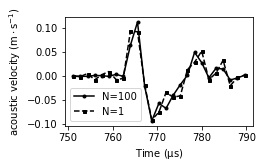

In [156]:
fig, ax = plt.subplots(1,1, figsize=(3.375, 2))
Cp.agg.plot(tmin=plot_tmin, tmax=plot_tmax, ax=ax, tunit="us", unit="m_s",
            marker="o", ms=3, c="k", ls="-", label="N=100")
Cp.collection[10].plot(tmin=plot_tmin, tmax=plot_tmax, ax=ax, tunit="us", unit="m_s",
                       marker="s", ms=3, c="k", ls="--", label="N=1")

#Cmic.agg.plot(tmin=plot_tmin, tmax=plot_tmax, ax=ax, tunit="us", unit=1,
#              marker="o", ms=3, c="crimson", ls="--", label="microphone (N=100)")
#Cmic.collection[10].plot(tmin=plot_tmin, tmax=plot_tmax, ax=ax, tunit="us", unit=1, 
#                         marker="s", ms=3, c="crimson", ls="-", label="microphone (N=1)")
#ax.set_ylabel("Acoustice velocity (m/s)")
plt.legend()
plt.savefig("figures/acoustic_velocity.png", bbox_inches="tight")

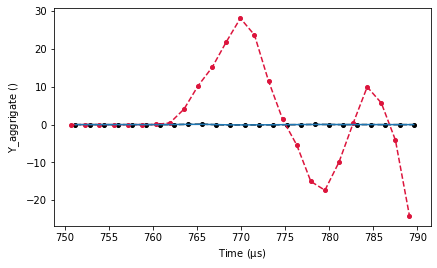

In [274]:
fig, ax = plt.subplots(1,1, figsize=(2*3.375, 4))
Cp.agg.plot(tmin=plot_tmin, tmax=plot_tmax, ax=ax, tunit="us", unit="Pa",
            marker="o", ms=4, c="k", ls="--", label="bead (N=100)")
Cmic.agg.plot(tmin=plot_tmin, tmax=plot_tmax, ax=ax, tunit="us", unit=4e-4,
              marker="o", ms=4, c="crimson", ls="--", label="microphone (N=100)")

pt_lp, p_lp = Cp.agg.lowpass(cutoff=150e3)
mask = np.logical_and(pt_lp>plot_tmin, pt_lp<plot_tmax)
ax.plot(pt_lp[mask]*1e6, p_lp[mask])

Text(0, 0.5, 'v ${\\rm (mm ~ s^{-1})}$')

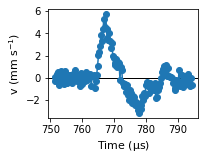

In [313]:
fig, ax = plt.subplots(1, 1, figsize=(2.7, 2.))
ax.plot(tbar*1e6, -xbar*1e3, marker="o")
ax.axhline(0, c="k", lw=1, zorder=0)
ax.set_xlabel(r"Time (${\rm \mu}$s)", size=11)
ax.set_ylabel(r"v ${\rm (mm ~ s^{-1})}$", size=11)
#plt.savefig("figures/100-avg_velocity-pulse.png", bbox_inches="tight", dpi=600)

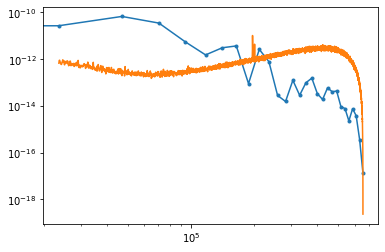

In [90]:
freq_pulse, psd_pulse, N = PSD(xbar, 1/C.r)
freq, psd = C.average("PSD")

plt.loglog(freq_pulse, psd_pulse, marker=".")
plt.loglog(freq[freq>freq_pulse[1]], psd[freq>freq_pulse[1]]*cal*cal)

In [153]:
(5/C.r)

2.800000000000003e-06

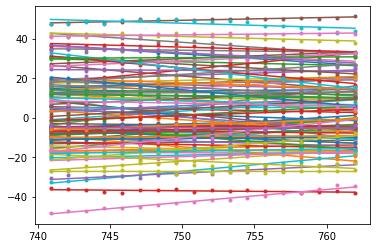

In [32]:
fnamei = 0
tmin, tmax = 740e-6, 763e-6
fname = sort_fnames(fnames)[fnamei]
C = Collection(fname)
cal = 1 / krhoATs[fnamei, -2]
m = 4 * np.pi * krhoATs[fnamei, 1] * C.R**3 / 3
k = krhoATs[fnamei, 0]

C.set_collection("X", bin_average=Npts)
C.apply("detrend", mode="constant", inplace=True)
xvbars = []
res = []
for Di, D in enumerate(C.collection):
    color = f"C{Di}"
    mask = np.logical_and(D.t>tmin, D.t<tmax)
    t, x = D.t[mask], D.x[mask]* cal
    vbar, b  = np.polyfit(t, x, deg=1)
    res.append((x - np.poly1d([vbar, b])(t)))
    xbar = b + vbar*(tmax*tmax-tmin*tmin) / (2*(tmax-tmin))
    xvbars.append([xbar, vbar])
    plt.plot(t*1e6, x*1e9, marker=".", ls="none",  color=color)
    plt.plot(t*1e6, (t*vbar+b)*1e9,  color=color)
    #plt.axhline(xbar*1e9, color=color)
xvbars = np.array(xvbars)
res = np.array([el for r in res for el in r])


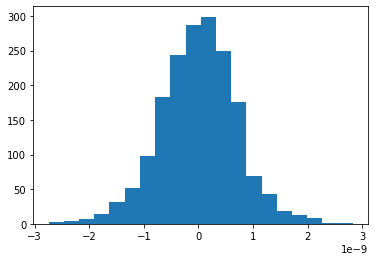

In [33]:
plt.hist(res, bins=20);

In [34]:
E = k * xvbars[:, 0]**2 / 2 + m * xvbars[:, 1]**2 / 2
inds = np.argsort(E)

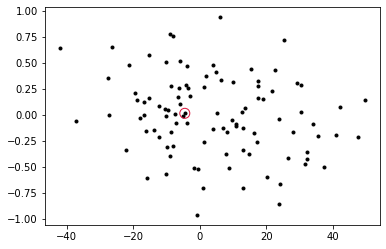

In [35]:
plt.scatter(xvbars[:, 0]*1e9, xvbars[:, 1]*1e3, marker=".", c="k")
plt.scatter([xvbars[inds[0], 0]*1e9], [xvbars[inds[0], 1]*1e3], ec="crimson", fc="none", s=100)

In [1304]:
def dBre(x, re):
    return 20*np.log10(x/re)
Pastar = 2.4e-3
def muflown_amp(f, lfs=Z*240.1/Pastar, f1=72, f2=750, f3=21.910):
    denom = lfs / np.sqrt((1 + (f1/f)**2) * (1 + (f/f2)**2) * (1 + (f/f3)**2))

# Calibration

In [8]:
fname0 = find_files('/data/brownian/20220330/bead1/baseline')[0]

In [9]:
reload(brownian)
reload(acoustic_entrainment)
reload(time_series)
from acoustic_entrainment import VelocityResponse
from time_series import Collection
from brownian import get_params_from_abcRT, abc_guess, logbin_func, psd_func

from constants import kB
from scipy.integrate import cumulative_trapezoid
def psd_calibration(fname,
                   fmin=5e2, fmax=4e4, bin_average_Npts=32, cutoff=500e3, taumax=100e-3, plot=False
                   ):
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(6,4))
        #axins = inset_axes(ax, width="45%", height="40%", loc="lower left", borderpad=2.3)
        color="k"
    C = Collection(fname)
    T = np.mean(C.Ts) + 273.15
    C.set_collection("X")
    C.apply("detrend", inplace=True, mode="constant")
    C.apply("lowpass", cutoff=cutoff, order=3, inplace=True)
    C.apply("bin_average", Npts=bin_average_Npts, inplace=True)
    freq, psd = C.average("PSD", window="hamming", taumax=taumax)
    mask = np.logical_and(freq>fmin, freq<fmax)
    abc, abc_cov = abc_guess(freq[mask], psd[mask], n=C.Navg_psd)
    cal_params = get_params_from_abcRT(*abc, C.R, T)
    C.params.update(cal_params)
    psd *= C.cal**2
    xnoise2 = np.mean(psd[freq>2e5])
    C.xnoise2 = xnoise2
    if plot:

        logfreq  = logbin_func(freq, Npts=20)
        logpsd  = logbin_func(psd, Npts=20)
        logmask = np.logical_and(logfreq>fmin, logfreq<fmax)
        ax.loglog(logfreq, logpsd, mec=color, mfc="none", marker="o", ls="none")
        line_mask = np.logical_and(freq>50, freq<1e6)
        ax.loglog(freq[line_mask], psd_func(freq, C.k, C.rho, C.T, C.R)[line_mask]+xnoise2, c=color)
        #ax.axhline(xnoise2)
        ax.axvline(fmin, c="k", lw=1)
        ax.axvline(fmax, c="k", lw=1)
        #axins.plot(freq, psd, c=color, marker=".", ls="none")
        #axins.set_xlim(500, 7000)
        #axins.set_ylim(0.9e-20, 5.1e-20)
        ax.set_ylabel(r"PSD $\rm (m^2 Hz^{-1})$")
        ax.set_xlabel(r"Frequency (Hz)")
        ax.set_xlim(right=cutoff)
        ax.set_ylim(bottom=1e-25)
        return C, ax
    return C

def cPSD(freq, psd, initial=None):
    if initial is None:
        initial = psd[0]*(freq[1]-freq[0])
    return cumulative_trapezoid(psd, x=freq, initial=initial)

100 0.041942480000000004 1315789.4736842103 4.808511267458445e-06 1533.3286122544719 4.658234255818324e-06 5.80944727033833e-24


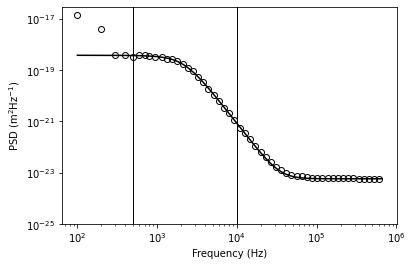

In [10]:
C0, ax = psd_calibration(fname0, taumax=10e-3, fmin=5e2, fmax=1e4, bin_average_Npts=20, cutoff=None, plot=True)
response = VelocityResponse(R=C0.R, rho=C0.rho, T=C0.T, c0=344, k=C0.k)
print(C0.Navg_psd, C0.t[-1], C0.r, C0.k, C0.rho, C0.cal, C0.xnoise2)

## Variance estimation and low pass filtering via bin averaging

In [24]:
vvar = kB*C0.T/C0.m
C0.set_collection("X")
C0.apply("calibrate", cal=C0.cal, inplace=True)
C0.apply("detrend", mode="constant", inplace=True)
C0.apply("bin_average", Npts=2, inplace=True)
C0.apply("differentiate", inplace=True)
freq, psd = C0.average("PSD", taumax=100e-3)
cpsd = cPSD(freq, psd, initial=0)
fopt = freq[np.argmin(np.abs(cpsd-vvar))]
Dfopt = 5e4
mask = np.logical_and(freq<fopt+Dfopt,  freq>fopt-Dfopt)



obs_freqs = np.geomspace(3e2,5e5,3)
obs_vars = []
dobs_vars = []
for obs_freq in obs_freqs:
    C0.set_collection("X")
    C0.apply("calibrate", cal=C0.cal, inplace=True)
    C0.apply("detrend", mode="constant", inplace=True)
    Npts = C0.r // (2*obs_freq) 
    print(Npts, obs_freq)
    C0.apply("bin_average", Npts=Npts, inplace=True)
    C0.apply("differentiate", inplace=True)
    obs_var_list = [np.var(D.x) for D in C0.collection]
    obs_vars.append(np.mean(obs_var_list))
    dobs_vars.append(np.std(obs_var_list))
ops_vars = np.array(obs_vars)
dops_vars = np.array(dobs_vars)

41666.0 300.0
1020.0 12247.448713915892
25.0 500000.0


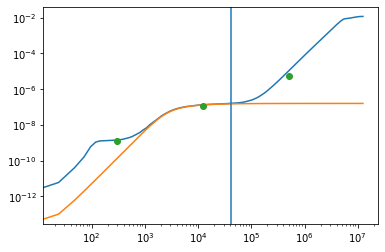

In [29]:
plt.loglog(freq, cpsd)
plt.loglog(freq, cPSD(freq, response.Sv_stokes(freq), initial=0))
plt.axvline(fopt)
plt.errorbar(obs_freqs, obs_vars, yerr=dobs_vars, ls="none", marker="o")
ax = plt.gca()
def Npts_func(f):
    C0.set_collection("X")
    return C0.r // (2*f)
#ax.secondary_xaxis("top", functions=(Npts_func, Npts_func))

## Response function 

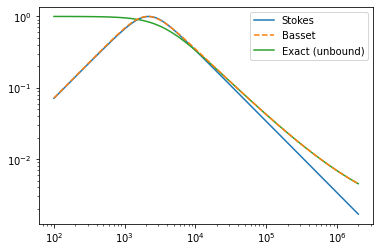

In [93]:
reload(acoustic_entrainment)
fs = np.geomspace(1e2,2e6,100)
plt.loglog(fs, response.amplitude("stokesbound", fs), label="Stokes")
plt.loglog(fs, response.amplitude("bassetbound", fs), label="Basset", ls="--",zorder=10)
plt.loglog(fs, response.amplitude("exact", fs), label="Exact (unbound)")
plt.legend()

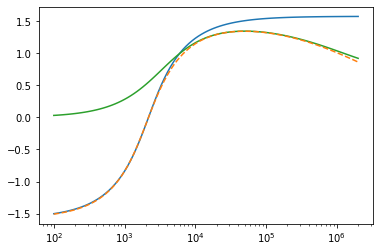

In [94]:
plt.semilogx(fs, response.phase("stokesbound", fs))
plt.semilogx(fs, response.phase("bassetbound", fs), ls="--",zorder=10)
plt.semilogx(fs, response.phase("exact", fs))

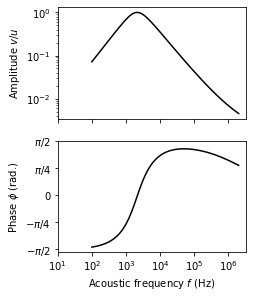

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(3.375, 4.5), sharex=True)
axs[0].loglog(fs, response.amplitude("bassetbound", fs), label="Basset", c="k")
axs[1].semilogx(fs, response.phase("bassetbound", fs), label="Basset", c="k")
axs[0].set_ylabel(r"Amplitude $v/u$")
axs[1].set_ylabel(r"Phase $\phi$ (rad.)")
axs[1].set_xlabel("Acoustic frequency $f$ (Hz)")
axs[1].set_yticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])
axs[1].set_xticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
axs[1].set_yticklabels([r"$-\pi/2$", r"$-\pi/4$", 0, r"$\pi/4$", r"$\pi/2$"]);
#plt.savefig("figures/response.png", bbox_inches="tight")

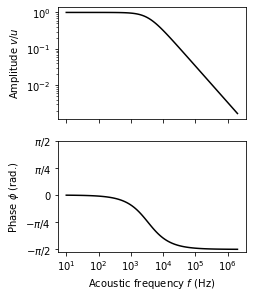

In [180]:
fig, axs = plt.subplots(2, 1, figsize=(3.375, 4.5), sharex=True)
resp = response.Gamma/(response.Gamma + 1j*2*np.pi*fs)
amp = np.abs(resp)
phase = np.angle(resp)
axs[0].loglog(fs, amp, label="stokes", c="k")
axs[1].semilogx(fs, phase, label="stokes", c="k")
axs[0].set_ylabel(r"Amplitude $v/u$")
axs[1].set_ylabel(r"Phase $\phi$ (rad.)")
axs[1].set_xlabel("Acoustic frequency $f$ (Hz)")
axs[1].set_yticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])
axs[1].set_xticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6])
axs[1].set_yticklabels([r"$-\pi/2$", r"$-\pi/4$", 0, r"$\pi/4$", r"$\pi/2$"]);
plt.savefig("figures/response_stokes.png", bbox_inches="tight")

## Pressure self noise, sensitivity, and minimum

In [14]:
cutoff = 1e6
Npts = C0.r // (2*cutoff)
C0.set_collection("X")
C0.apply("calibrate", cal=C0.cal, inplace=True)
C0.apply("detrend", inplace=True, mode="constant")
C0.apply("bin_average", Npts=Npts, inplace=True)
C0.apply("differentiate", inplace=True)
C0.apply_func(response.correct_signal, tmin=C0.t[0], tmax=C0.t[-1],
              correction="bassetbound", window="boxcar", impedance=None, r0=5e-2)

In [15]:
C0.average("PSD", taumax=1e-3);

In [37]:
C0.xnoise2

5.80944727033833e-24

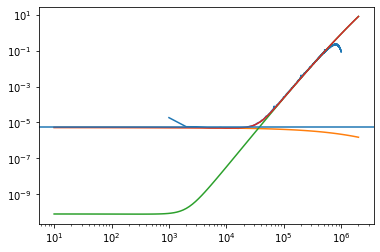

In [16]:
fs = C0.freq[1:]
Z = response.plane_impedance(0,0)
plt.loglog(fs[fs<1e6], C0.psd[1:][fs<1e6]*Z**2)
fs = np.geomspace(1e1, 2e6, 100)
plt.loglog(fs, response.Sv_basset(fs)/((response.amplitude("bassetbound", fs)/Z)**2))
plt.loglog(fs, (C0.xnoise2 * (2*np.pi*fs)**2)/((response.amplitude("bassetbound", fs)/Z)**2))
plt.loglog(fs, response.Sv_basset(fs, chi=C0.xnoise2) /((response.amplitude("bassetbound", fs)/Z)**2))
#plt.loglog(fs, (3/2)**6 * xnoise2 * (Z*2*np.pi*fs/response.delta)**2 -6561/128 * xnoise2*(2*np.pi*fs)**(3/2)/np.sqrt(response.delta**5*response.taup))

d = response.delta
G = 1/response.taup
ws = 2*np.pi*fs
w0 = response.w0
kT = kB * C0.T
m = response.m
#plt.loglog(fs, 729*xnoise2/(64*d*d)*(2*np.pi*fs)**2)
plt.axhline(4*kT/response.gamma*Z**2)

In [102]:
np.sqrt(4*kT/response.gamma*(1e5))

0.0017268795447376256

In [17]:
def dBre(x, re):
    return 20*np.log10(x/re)
Pastar = 2.4e-3
def muflown_amp(f, lfs=240.1/Pastar, f1=72, f2=750, f3=21.910):
    return lfs / np.sqrt((1 + (f1/f)**2) * (1 + (f/f2)**2) * (1 + (f/f3)**2))


# Piezo shaker drive

In [18]:
shaker_ders = find_ders('/data/brownian/20220330/bead1')

In [19]:
def to_kHz(s):
    try:
        return float(s)
    except:
        return 0
drives = [to_kHz(path.basename(der).split("kHz")[0]) for der in shaker_ders]
ders_sorted = [der for _, der in sorted(zip(drives, shaker_ders))[2:]]
drives_sorted = sorted(drives)[2:]
drives_sorted

[10.0,
 20.0,
 30.0,
 40.0,
 50.0,
 100.0,
 150.0,
 400.0,
 500.0,
 600.0,
 1000.0,
 1000.0]

In [20]:
ders_sorted

['/data/brownian/20220330/bead1/10kHz_50V_30ms',
 '/data/brownian/20220330/bead1/20kHz_50V_30ms',
 '/data/brownian/20220330/bead1/30kHz_50V_30ms',
 '/data/brownian/20220330/bead1/40kHz_50V_30ms',
 '/data/brownian/20220330/bead1/50kHz_50V_30ms',
 '/data/brownian/20220330/bead1/100kHz_50V_30ms',
 '/data/brownian/20220330/bead1/150kHz_50V_30ms',
 '/data/brownian/20220330/bead1/400kHz_50V_30ms',
 '/data/brownian/20220330/bead1/500kHz_50V_30ms',
 '/data/brownian/20220330/bead1/600kHz_50V_30ms',
 '/data/brownian/20220330/bead1/1000kHz_238V_30ms',
 '/data/brownian/20220330/bead1/1000kHz_50V_30ms']

In [21]:
reload(time_series)
from time_series import Collection,TimeSeries
cutoff = 1e6
Cs = []
for der, fdrive in zip(ders_sorted, drives_sorted[:]):
    print(fdrive)
    fdrive *= 1e3
    fname = find_files(der)[0]
    C = Collection(fname)
    C.fdrive = fdrive
    C.set_collection("X")
    Npts = C.r // (2*cutoff)
    C.apply("calibrate", cal=C0.cal, inplace=True)
    C.apply("detrend", inplace=True, mode="constant")
    C.apply("bin_average", Npts=Npts, inplace=True)
    C.apply("differentiate", inplace=True)
    C.apply_func(response.correct_signal, tmin=C.t[0], tmax=C.t[-1],
              correction="bassetbound", window="boxcar", impedance="plane", r0=5e-2)
    C.average("PSD", taumax=20e-3)
    Cs.append(C)

10.0
20.0
30.0
40.0
50.0
100.0
150.0
400.0
500.0
600.0
1000.0
1000.0


In [22]:
C0.set_collection("X")
Npts = C0.r // (2*cutoff)
C0.apply("calibrate", cal=C0.cal, inplace=True)
C0.apply("detrend", inplace=True, mode="constant")
C0.apply("bin_average", Npts=Npts, inplace=True)
C0.apply("differentiate", inplace=True)
C0.apply_func(response.correct_signal, tmin=C0.t[0], tmax=C0.t[-1],
              correction="bassetbound", window="boxcar", impedance=None, r0=5e-2)
C0.average("PSD", taumax=20e-3)

(array([0.00000000e+00, 5.00006000e+01, 1.00001200e+02, ...,
        1.13626364e+06, 1.13631364e+06, 1.13636364e+06]),
 array([2.95881080e-10, 2.11561659e-09, 3.43797811e-09, ...,
        4.56501944e-13, 2.77671346e-12, 6.67136786e-12]))

10.0 6.29599105360541
20.0 54.37893872255214
30.0 11428.915234362426
40.0 18235.865069894728
50.0 2714.3822212129367
100.0 58.40497053805296
150.0 9992.491930429442
400.0 772.4830473812082
500.0 24.098193417325703
600.0 4.553526224235965


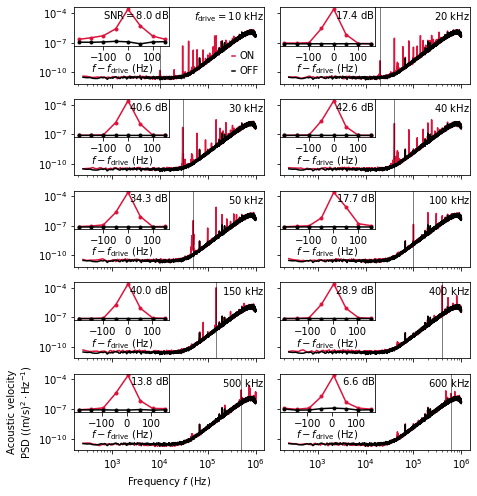

In [273]:
Nrow, Ncol = 5, 2
fig, axs = plt.subplots(Nrow, Ncol, figsize=(2*3.375, 7), sharex=True, sharey=True)
SNRs = []
for ii, (C, fdrive) in enumerate(zip(Cs, drives_sorted[:-2])):
    r = ii // Ncol
    c = ii % Ncol
    ax = axs[r, c]
    inax = ax.inset_axes((0, 0.5, 0.5, 0.5))
    fdrive *= 1e3
    Deltaf =  400
    freq, psd = C.freq, C.psd
    inmask = np.logical_and(freq>fdrive-Deltaf/2, freq<min(fdrive+Deltaf/2, 2.0e6))
    inmask0 = np.logical_and(C0.freq>fdrive-Deltaf/2, C0.freq<min(fdrive+Deltaf/2, 2.0e6))
    mask = np.logical_and(freq<cutoff, freq>230)
    mask0 = np.logical_and(C0.freq<cutoff, C0.freq>230)
    ax.loglog(freq[mask], psd[mask], c="crimson", label="ON")
    ax.loglog(C0.freq[mask0], C0.psd[mask0], c="k", label="OFF")
    ax.axvline(fdrive, lw=0.5, c="k")
    ax.plot(freq[mask], response.Sv_basset(C.freq, chi=C0.xnoise2)[mask]/response.power("bassetbound", C.freq)[mask])
    inax.plot(freq[inmask]-fdrive, psd[inmask]*1e6, marker=".", c="crimson")
    inax.plot(C0.freq[inmask0]-fdrive, C0.psd[inmask0]*1e6, marker=".", c="k")
    max_dex = np.argmax(psd[inmask])
    mx = psd[inmask][max_dex]
    mn = C0.psd[inmask0][max_dex]
    SNR = mx/mn
    SNRs.append(SNR)
    print(fdrive/1e3, SNR)
    if c==0 and r==0:
        drive_str = r"$f_{\rm drive} = %s$ kHz" % (int(fdrive/1e3)) 
        SNR_str = r"${\rm SNR} = %s$ dB" % (round(10*np.log10(mx/mn),1))
    else:
        drive_str = r"$%s$ kHz" % (int(fdrive/1e3)) 
        SNR_str = r"$%s$ dB" % (round(10*np.log10(mx/mn),1))
    ax.text(1, 0.96, drive_str, transform=ax.transAxes, va="top", ha="right")
    inax.text(1, 0.96, SNR_str, transform=inax.transAxes, va="top", ha="right")
    inax.set_yticks([])
    inax.set_xticks([-100, 0, 100])
    inax.set_xlabel(r"$f-f_{\rm drive}$ (Hz)", labelpad=0)
#axs[-1,0].set_yscale("log")
axs[-1, 0].set_yticks([1e-10, 1e-7, 1e-4])
axs[-1, 0].set_xlabel(r"Frequency $f$ (Hz)")
axs[-1, 0].set_ylabel("Acoustic velocity\n"+ r"PSD $\rm ((m/s)^2 \cdot Hz^{-1})$")
axs[0, 0].legend(frameon=False, handlelength=0.3, handletextpad=0.5, loc="lower right", bbox_to_anchor=(1.02, -0.02))
plt.tight_layout()
#plt.savefig("figures/shaker_PSD_peaks.pdf", bbox_inches="tight")

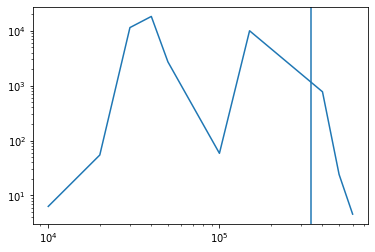

In [269]:
plt.loglog(np.array(drives_sorted[:-2])*1e3, SNRs)
plt.axvline(343e3)

### 50 kHz

In [23]:
C = Cs[4]
C.fdrive

50000.0

In [43]:
from scipy.signal import find_peaks

In [ ]:
idxs = np.arange(len(freq))
freq_threshed = freq[thresh_mask]
psd_threshed = psd[thresh_mask]
idxs_threshed = idxs[thresh_mask]
_idx = np.r_[0, np.where(np.diff(freq) >= resolution)[0]+1, len(freq_threshed)]
freq_groups = [freq_threshed[i:j] for i,j in zip(_idx, _idx[1:])]
psd_groups = [psd_threshed[i:j] for i,j in zip(_idx, _idx[1:])]
idx_groups = [idxs_threshed[i:j] for i,j in zip(_idx, _idx[1:])]

psd_peaks = []
freq_peaks = []
idx_peaks = []
for fs, ps, inds in zip(freq_groups, psd_groups, idx_groups):
    if len(fs) > 0:
        max_dex = np.argmax(ps)
        pmax = ps[max_dex]
        fmax = fs[max_dex]
        indmax = inds[max_dex]
        psd_peaks.append(pmax)
        freq_peaks.append(fmax)
        idx_peaks.append(indmax)
plt.plot(freq_peaks, psd_peaks, marker="o", mec="crimson", mfc="none")

<ipython-input-75-1f5fdca7c109>:3: RuntimeWarning: invalid value encountered in true_divide
  noise_model = response.Sv_basset(freq, chi=C0.xnoise2)/response.power("bassetbound", freq)


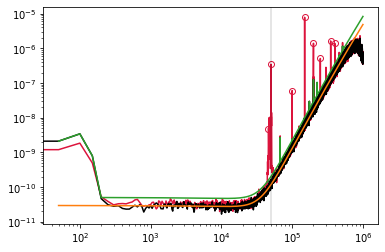

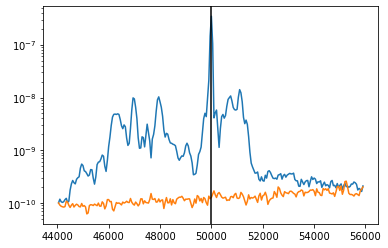

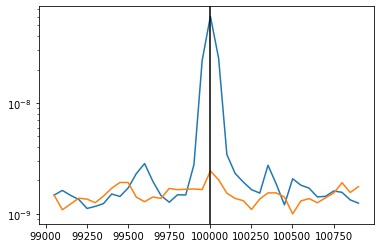

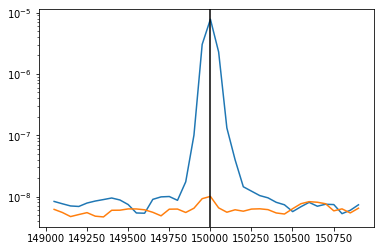

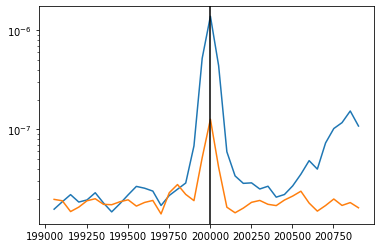

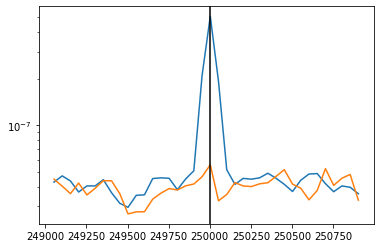

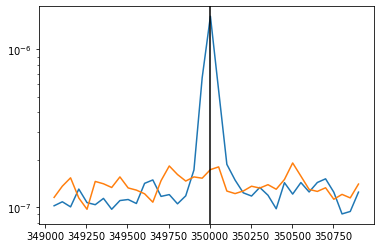

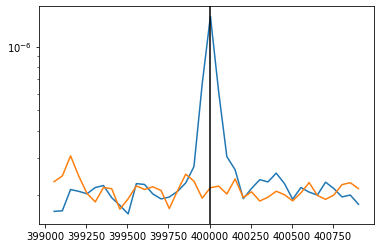

In [75]:
freq, psd = C.freq[C.freq<cutoff], C.psd[C.freq<cutoff]
freq0, psd0 = C0.freq[C0.freq<cutoff], C0.psd[C0.freq<cutoff]
noise_model = response.Sv_basset(freq, chi=C0.xnoise2)/response.power("bassetbound", freq)
dnoise_model = 5 * noise_model / np.sqrt(C.Navg_psd)
resolution = freq[1] - freq[0]
thresh_mask = psd > (noise_model + dnoise_model)


height = np.maximum(noise_model+dnoise_model, psd0)
peaks, props = find_peaks(psd/psd0, height=height, distance=75, prominence=3)

plt.plot(freq[peaks], psd[peaks], marker="o", mec="crimson", mfc="none", ls="none")

plt.plot(freq, psd, c="crimson")
plt.plot(freq0, psd0, c="k")
plt.plot(freq, noise_model)
plt.plot(freq, height)
plt.axvline(C.fdrive, lw=0.2, c="k")
plt.xscale("log")
plt.yscale("log")
plt.show()

for peaki, peak in enumerate(peaks[1:]):
    if freq[peak] <60e3:
        width = int(12000 /(freq[1] - freq[0]) // 2)
    else:
        width = int(2000 /(freq[1] - freq[0]) // 2)
    freq_peak = freq[peak]
    psd_peak = psd[peak]
    plt.plot(freq[peak-width: peak+width], psd[peak-width: peak+width])
    plt.plot(freq0[peak-width: peak+width], psd0[peak-width: peak+width])
    plt.axvline(freq_peak, c="k")
    plt.yscale("log")
    plt.show()
    

# Spectral density convention check

In [731]:
from numpy.fft import fft, fftfreq
C0.set_collection("X")
C0.apply("detrend", mode="constant", inplace=True)
C0.apply("bin_average", Npts=25, inplace=True)
fs = C0.r
x = C0.collection[0].x[2:]
N = x.size
parity = N % 2
freqs = fftfreq(N, 1/fs)[:upper_index]
if parity:
    upper_index  = (N//2) + 1
    slc = slice(1, None, None)
else:
    upper_index = (N + 1) // 2
    slc = slice(1, -1, None)
    #freqs[-1] *= -1
xhat = fft(x, n=len(x))[:upper_index]
P = np.real(np.conj(xhat) * xhat)
P[slc] *= 2
P /= (fs*N)

In [1011]:
C0.set_collection("X")

In [1016]:
C0.r, C0.size, C0.t[-1]

(25000000.0, 1048576, 0.041943)

In [1309]:
xnoise2

5.491731368447791e-24

In [738]:
freqs2, P2, nn = C0.collection[0].PSD(taumax=1e-3)

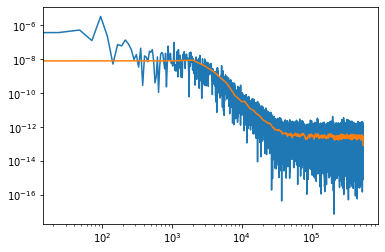

In [739]:
plt.loglog(freqs, P)
plt.loglog(freqs2, P2)

In [1561]:
eps = response.eps(fs)
Weps = Wresponse.eps(fs)
def ratio(eps):
    return (1+eps) / ((1+eps)**2+eps**2*(1+2*eps/3)**2)
    

In [195]:
1/3.2e-6

312500.0

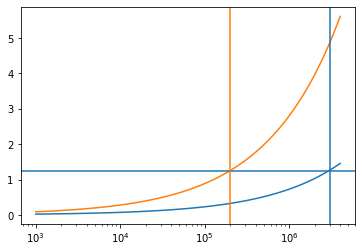

In [1563]:
fs = np.geomspace(1e3, 4e6, 100)
eps = response.eps(fs)
Weps = Wresponse.eps(fs)
plt.plot(fs, eps)
plt.semilogx(fs, Weps)
plt.axhline(1.23)
plt.axvline(3e6, c="C0")
plt.axvline(2e5, c="C1")

In [1142]:
10*np.log10(3/8 * response.c0*C0.T*kB*response.delta/C0.R / 1e-12)

-35.203794184934495

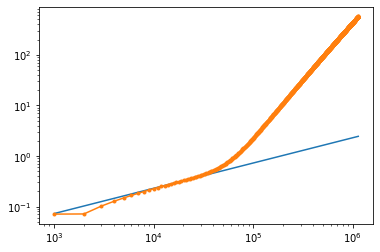

In [1179]:

ppsd =  (Snn(2*np.pi*fs)+SVV(2*np.pi*fs))/((response.amplitude_ratio_bassetbound(fs)/Z)**2)
cppsd =cPSD(fs, ppsd)
plt.loglog(fs, Z*np.sqrt(4*kB*T/response.gamma * fs))
plt.loglog(fs, np.sqrt(cppsd), marker=".")


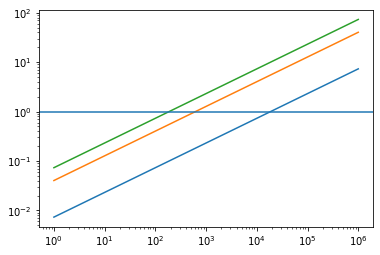

In [99]:
for a in np.linspace(10e-9, 100e-9, 3):
    fs = np.linspace(1,1e6,1000)
    plt.loglog(fs, 2*a*np.sqrt(fs) / np.sqrt(kB*C0.T/(C0.gamma)))
plt.axhline(1)

In [80]:
D = kB*C0.T/(C0.gamma)
for U in (1e-9, 1e-6, 1e-3):
    fs = np.linspace(1,1e6,1000)
    plt.loglog(fs, (U/fs) / ( np.sqrt(kB*C0.T/C0.m))/fs )
plt.axhline(1)

2.9034645980106913e-08

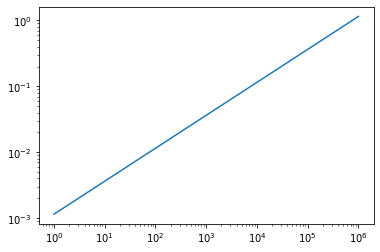

In [107]:
 plt.loglog(fs, response.Z0*np.sqrt(D*fs))

In [110]:
response.Gamma

21260.230083602193